### **Métodos de Optimización**
#### Prácticas computacionales de "Introducción a los Algoritmos Genéticos y Optimización Estocástica"

Instrucciones para los Ejercicios

1. **Trabajo en Grupo:**
   - Los ejercicios deben ser resueltos y entregados en grupo.
   - La cantidad de integrantes por grupo será definida el día de la actividad, así como la fecha límite para la entrega.

2. **Uso de Google Colab y Compartir:**
   - Este notebook debe ser copiado al GitHub o Google Drive de alguno de los integrantes del grupo.
   - El grupo será responsable de programar las soluciones, realizar las pruebas y enviar el trabajo final al profesor.

3. **Implementación de los Ejercicios:**
   - Cada ejercicio debe ser implementado de manera que cumpla con los objetivos específicos descritos en cada problema.
   - El código debe devolver claramente la información calculada de acuerdo a lo solicitado.

4. **Calidad del Código:**
   - El código debe ejecutarse sin errores.
   - Es obligatorio incluir **comentarios explicativos** para describir las ideas y conceptos implícitos en el código, facilitando la comprensión de su lógica.

5. **Envío del Trabajo:**
   - Una vez completado, el notebook debe ser enviado a través de Moodle.
   - En caso de dudas, pueden contactarme por correo electrónico a **marcelo.danesi@utec.edu.uy**.

6. **Orientaciones Adicionales:**
   - Asegúrense de que todas las celdas de código hayan sido ejecutadas antes de enviar.
   - Incluyan el nombre completo y correo electrónico de todos los integrantes al inicio del notebook.
   - Si utilizan referencias externas, menciónenlas de forma adecuada.

¡Buena suerte y aprovechen la práctica para consolidar los conceptos de métodos optimización!

#### **Introducción a los Algoritmos Genéticos y Optimización Estocástica**

**Nota:** Este notebook sigue la línea conceptual del capítulo teórico. Aquí entrenamos la práctica y la lectura crítica de resultados.

##### **1. Algoritmos Genéticos (AG) — ejemplo guiado 1D**

**Problema base:** Minimizar
$$f(x)=x^2+\sin(5x),\qquad x\in[-5,5].$$

La idea es construir el AG **por etapas**, mostrando:
1. cómo se crea la población inicial,
2. cómo medimos desempeño (fitness),
3. cómo seleccionamos padres,
4. cómo generamos hijos (cruce),
5. cómo exploramos (mutación + recorte al dominio),
6. cómo preservamos lo mejor (elitismo),
7. y finalmente cómo **iteramos** esto generación tras generación.

Al final, presentamos la versión compacta del algoritmo y lo comparamos con la versión paso a paso.

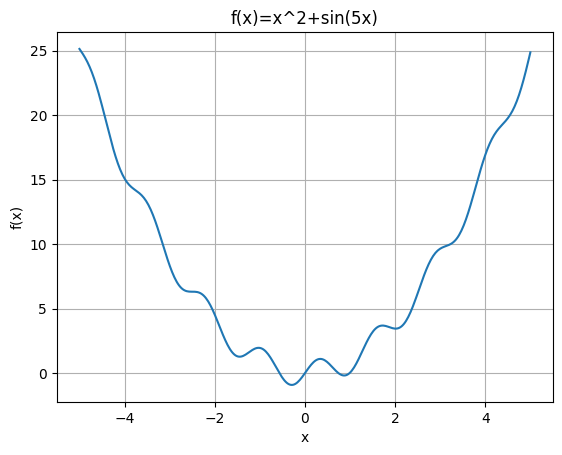

In [ ]:
# 0. Imports y función objetivo

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

def f1d(x):
    return x**2 + np.sin(5*x)

# vista rápida de la función
xs = np.linspace(-5,5,400)
plt.figure()
plt.plot(xs, f1d(xs))
plt.xlabel("x"); plt.ylabel("f(x)"); plt.title("f(x)=x^2+sin(5x)")
plt.grid(True); plt.show()

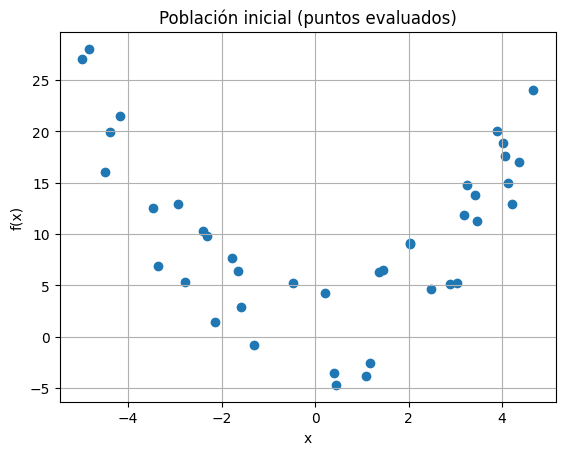

In [ ]:
# 1. Población inicial (exploración uniforme del dominio)
# **Idea:** empezamos con `N` candidatos $x_i$ tomados **uniformemente** en $[-5,5]$.
# Esto da diversidad inicial sin sesgo.

def init_population(pop_size=40, bounds=(-5,5), rng=None):
    if rng is None: rng = np.random.default_rng()
    a,b = bounds
    return rng.uniform(a,b,size=pop_size)

pop = init_population(pop_size=40, bounds=(-5,5), rng=rng)
plt.figure()
plt.scatter(pop, f1d(pop))
plt.xlabel("x"); plt.ylabel("f(x)"); plt.title("Población inicial (puntos evaluados)")
plt.grid(True); plt.show()

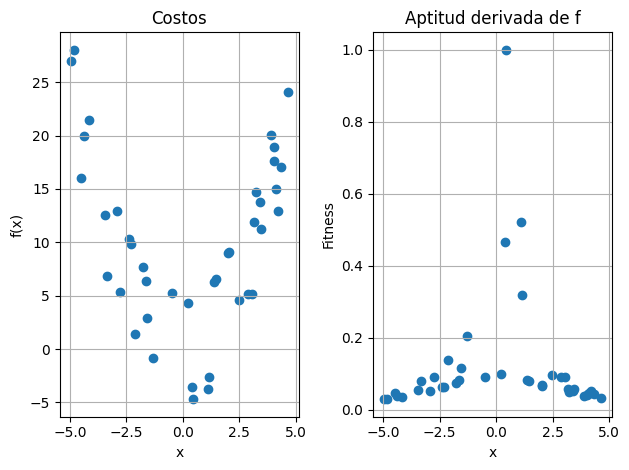

In [ ]:
# 2. Evaluación y **fitness**
# **Idea:** convertimos el costo $f(x)$ en una aptitud positiva $F(x)$ para poder
# hacer **selección por ruleta**. Un mapeo simple: $F(x)=1/(1 + f(x)-\min f)$.
# Esto conserva orden, evita valores negativos y no “aplana” demasiado las diferencias.

def fitness_from_objective(vals):
    vmin = np.min(vals)
    fit = 1.0 / (1.0 + (vals - vmin))
    eps = 1e-12
    return np.maximum(fit, eps)

vals = f1d(pop)
fit  = fitness_from_objective(vals)

plt.figure()
plt.subplot(1,2,1); plt.scatter(pop, vals); plt.xlabel("x"); plt.ylabel("f(x)"); plt.title("Costos")
plt.grid(True)
plt.subplot(1,2,2); plt.scatter(pop, fit); plt.xlabel("x"); plt.ylabel("Fitness"); plt.title("Aptitud derivada de f")
plt.grid(True); plt.tight_layout(); plt.show()

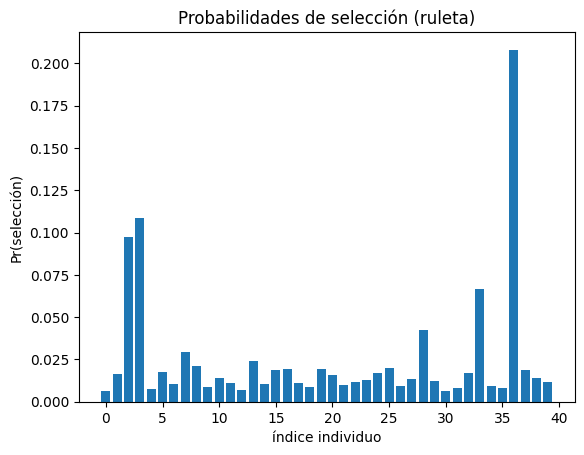

In [ ]:
# 3. Selección (ruleta)
# **Idea:** elegimos índices de padres proporcionalmente a su **fitness**. Mejores individuos
# tienen más chances, pero no excluimos totalmente a los demás → se mantiene diversidad.

def select_parents(pop, fit, rng=None):
    if rng is None: rng = np.random.default_rng()
    probs = fit / fit.sum()
    idx = rng.choice(pop.size, size=pop.size, p=probs, replace=True)
    return pop[idx], idx, probs

parents, parents_idx, probs = select_parents(pop, fit, rng=rng)

plt.figure()
plt.title("Probabilidades de selección (ruleta)")
plt.bar(np.arange(probs.size), probs)
plt.xlabel("índice individuo"); plt.ylabel("Pr(selección)")
plt.show()

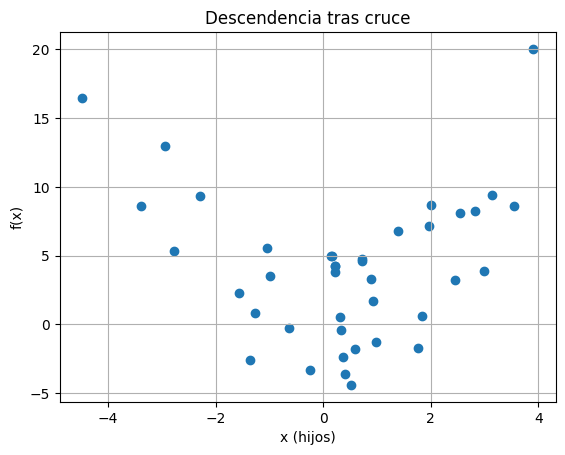

In [ ]:
# 4. Cruce aritmético
# **Idea:** combinamos de a pares $(p_1,p_2)$ con una mezcla lineal
# $\text{child}=\alpha p_1 + (1-\alpha)p_2$, con $\alpha\in[0,1]$ aleatoria.
# Así generamos **nueva** información entre padres.

def crossover_arithmetic(parents, cx_rate=0.8, rng=None):
    if rng is None: rng = np.random.default_rng()
    n = parents.size
    offspring = []
    for i in range(0, n, 2):
        p1 = parents[i]
        p2 = parents[i+1 if i+1 < n else 0]
        if rng.random() < cx_rate:
            alpha = rng.random()
            c1 = alpha*p1 + (1-alpha)*p2
            c2 = alpha*p2 + (1-alpha)*p1
        else:
            c1, c2 = p1, p2
        offspring.append(c1); offspring.append(c2)
    return np.array(offspring[:n])

offspring = crossover_arithmetic(parents, cx_rate=0.8, rng=rng)
plt.figure()
plt.scatter(offspring, f1d(offspring))
plt.xlabel("x (hijos)"); plt.ylabel("f(x)"); plt.title("Descendencia tras cruce")
plt.grid(True); plt.show()

Mutaciones aplicadas: 9


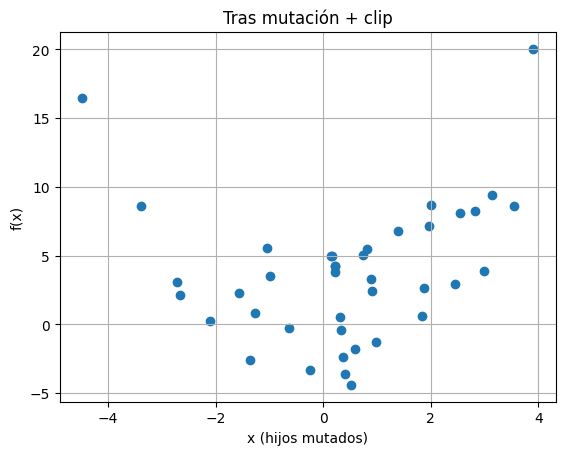

In [ ]:
# 5. Mutación gaussiana + recorte (respeto del dominio)
# **Idea:** aplicamos pequeñas perturbaciones normales (media 0, sigma pequeña) a una fracción de la descendencia.
# Esto evita el estancamiento en subóptimos. Luego **recortamos** al intervalo $[-5,5]$.

def mutate_and_clip(offspring, mut_rate=0.2, mut_sigma=0.1, bounds=(-5,5), rng=None):
    if rng is None: rng = np.random.default_rng()
    a,b = bounds
    n = offspring.size
    mask = rng.random(n) < mut_rate
    noise = rng.normal(0.0, mut_sigma, size=n)
    offspring = offspring.copy()
    offspring[mask] += noise[mask]
    offspring = np.clip(offspring, a, b)
    return offspring, int(mask.sum())

offspring_mut, muts = mutate_and_clip(offspring, mut_rate=0.2, mut_sigma=0.12, bounds=(-5,5), rng=rng)
print("Mutaciones aplicadas:", muts)

plt.figure()
plt.scatter(offspring_mut, f1d(offspring_mut))
plt.xlabel("x (hijos mutados)"); plt.ylabel("f(x)"); plt.title("Tras mutación + clip")
plt.grid(True); plt.show()

In [ ]:
# 6. Elitismo
# **Idea:** preservamos los mejores `E` individuos de la generación anterior para asegurar que **no se pierdan** por azar.
# Implementamos reemplazando los `E` **peores** de la nueva descendencia por los `E` **mejores** de la población previa.

def apply_elitism(prev_pop, prev_vals, offspring, f, elitism=1):
    if elitism <= 0:
        return offspring
    # mejores de la población anterior:
    elite_idx = np.argsort(prev_vals)[:elitism]
    elites = prev_pop[elite_idx]
    # peores de la descendencia:
    off_vals = f(offspring)
    worst_idx = np.argsort(-off_vals)[:elitism]
    offspring = offspring.copy()
    offspring[worst_idx] = elites
    return offspring

# demostración puntual
offspring_elite = apply_elitism(pop, vals, offspring_mut, f1d, elitism=1)
print("Elitismo aplicado (se preserva el mejor anterior).")

Elitismo aplicado (se preserva el mejor anterior).


Mejor f: -4.975424  en x=-0.1565  | evals~4840


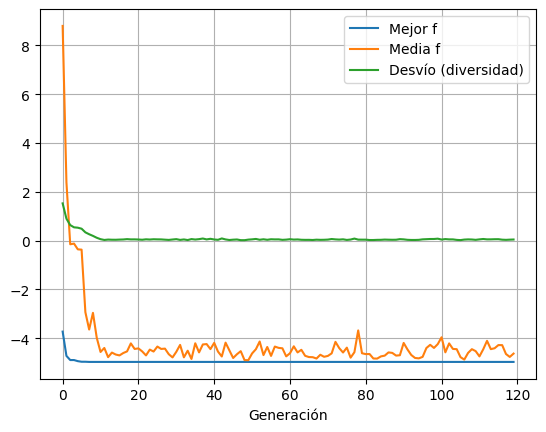

In [ ]:
# 7. Una generación completa (orquestación)
# Encapsulamos los pasos 2–6 en una función `one_generation` y luego iteramos por `G` generaciones.

def one_generation(pop, f, bounds, cx_rate, mut_rate, mut_sigma, elitism, rng=None):
    if rng is None: rng = np.random.default_rng()
    vals = f(pop)
    fit  = fitness_from_objective(vals)
    parents, _, _ = select_parents(pop, fit, rng=rng)
    offspring = crossover_arithmetic(parents, cx_rate=cx_rate, rng=rng)
    offspring, _ = mutate_and_clip(offspring, mut_rate=mut_rate, mut_sigma=mut_sigma, bounds=bounds, rng=rng)
    offspring = apply_elitism(pop, vals, offspring, f, elitism=elitism)
    return offspring, vals

def run_ag_step_by_step(
    f, bounds=(-5,5), pop_size=40, generations=120,
    cx_rate=0.8, mut_rate=0.2, mut_sigma=0.1, elitism=1, rng=None
):
    if rng is None: rng = np.random.default_rng()
    pop = init_population(pop_size, bounds, rng)
    best_hist, mean_hist, std_hist = [], [], []
    evals = 0
    for g in range(generations):
        pop, vals = one_generation(pop, f, bounds, cx_rate, mut_rate, mut_sigma, elitism, rng)
        evals += pop.size  # aproximación del costo de evaluación
        best_hist.append(vals.min()); mean_hist.append(vals.mean()); std_hist.append(pop.std())
    # evaluación final
    vals = f(pop); evals += pop.size
    best_idx = np.argmin(vals)
    return {
        "x_best": pop[best_idx],
        "f_best": vals[best_idx],
        "best_hist": np.array(best_hist),
        "mean_hist": np.array(mean_hist),
        "std_hist": np.array(std_hist),
        "evals": evals
    }

res = run_ag_step_by_step(
    f1d, bounds=(-5,5), pop_size=40, generations=120,
    cx_rate=0.8, mut_rate=0.2, mut_sigma=0.12, elitism=1, rng=np.random.default_rng(7)
)

print(f"Mejor f: {res['f_best']:.6f}  en x={res['x_best']:.4f}  | evals~{res['evals']}")
plt.figure()
plt.plot(res["best_hist"], label="Mejor f")
plt.plot(res["mean_hist"], label="Media f")
plt.plot(res["std_hist"], label="Desvío (diversidad)")
plt.xlabel("Generación"); plt.legend(); plt.grid(True); plt.show()

**Lectura:**  
- `Mejor f` ↓ rápido por selección+cruce;  
- `Media f` ↓ más suave (toda la población mejora gradualmente);  
- `Desvío` (diversidad) ↓ con el tiempo; si cae muy pronto → subí `mut_rate` o `mut_sigma`.

Mejor x: -0.1564537679924526   f(x): -4.975424292148998


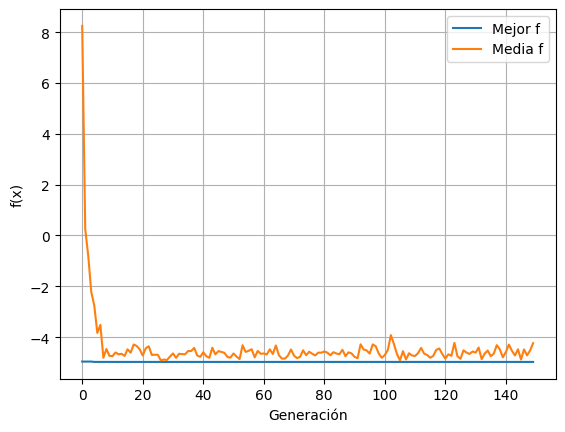

In [ ]:
# 8. Versión compacta (todo-en-uno) para reutilizar
# Ahora que comprendemos cada bloque, ofrecemos una función compacta que implementa el AG.
# Es la que se usa en experimentos más largos o en el resto del cuaderno.

def ag_minimize_1d(
    f, bounds=(-5.0, 5.0), pop_size=40, generations=150,
    cx_rate=0.8, mut_rate=0.2, mut_sigma=0.1, elitism=1, rng=None
):
    if rng is None:
        rng = np.random.default_rng()
    a, b = bounds
    pop = rng.uniform(a, b, size=pop_size)
    best_hist = []; mean_hist = []
    for g in range(generations):
        vals = f(pop)
        fit  = fitness_from_objective(vals)
        elites = pop[np.argsort(vals)[:elitism]] if elitism>0 else None

        probs = fit / fit.sum()
        parents_idx = rng.choice(pop_size, size=pop_size, p=probs, replace=True)
        parents = pop[parents_idx]

        # cruce
        offspring = []
        for i in range(0, pop_size, 2):
            p1 = parents[i]
            p2 = parents[i+1 if i+1 < pop_size else 0]
            if rng.random() < cx_rate:
                alpha = rng.random()
                c1 = alpha*p1 + (1-alpha)*p2
                c2 = alpha*p2 + (1-alpha)*p1
            else:
                c1, c2 = p1, p2
            offspring.append(c1); offspring.append(c2)
        offspring = np.array(offspring[:pop_size])

        # mutación + clip
        mut_mask = rng.random(pop_size) < mut_rate
        noise = rng.normal(0.0, mut_sigma, size=pop_size)
        offspring[mut_mask] += noise[mut_mask]
        offspring = np.clip(offspring, a, b)

        # elitismo
        if elitism > 0:
            off_vals = f(offspring)
            worst_idx = np.argsort(-off_vals)[:elitism]
            offspring[worst_idx] = elites

        pop = offspring
        best_hist.append(vals.min()); mean_hist.append(vals.mean())

    vals = f(pop)
    best_idx = np.argmin(vals)
    return pop[best_idx], vals[best_idx], np.array(best_hist), np.array(mean_hist)

best_x, best_val, bh, mh = ag_minimize_1d(f1d, rng=np.random.default_rng(11))
print("Mejor x:", best_x, "  f(x):", best_val)

plt.figure()
plt.plot(bh, label="Mejor f")
plt.plot(mh, label="Media f")
plt.xlabel("Generación"); plt.ylabel("f(x)"); plt.legend(); plt.grid(True); plt.show()

9. Checklist de comprensión
 - [ ] Identifico en el código **dónde** se inicializa la población y **por qué** es uniforme.
 - [ ] Entiendo cómo se calcula el **fitness** a partir de $f(x)$ y por qué debe ser positivo.
 - [ ] Puedo explicar la **selección por ruleta** y su efecto en diversidad.
 - [ ] Sé cómo funciona el **cruce aritmético** y su relación con el dominio.
 - [ ] Puedo justificar la **mutación** y el **recorte** al intervalo.
 - [ ] Entiendo el propósito del **elitismo** y cuándo conviene usarlo.
 - [ ] Puedo estimar el costo en **evaluaciones de $f$** y discutir su impacto computacional.


 ---

**Tarea 1 - Análisis del Algoritmo Genético (AG)**  
Después de ejecutar el código completo del AG y observar las gráficas de evolución:

1. **Analizá** cómo varían las curvas de `Mejor f` y `Media f`.  
   ¿Qué indican sus diferencias? ¿Qué te sugiere sobre la diversidad de la población?
2. **Identificá** en el código cada etapa conceptual del AG:  
   inicialización, evaluación, selección, cruce, mutación y elitismo.  
   Escribí una línea de comentario sobre qué hace cada bloque.
3. **Experimentá** con distintos parámetros (`cx_rate`, `mut_rate`, `mut_sigma`, `elitism`).  
   Observá el impacto en la convergencia y documentá brevemente tus conclusiones.

**Entrega esperada:**  
Un breve texto (5-10 líneas) explicando qué combinación de parámetros te dio mejores resultados y por qué, junto con las gráficas que lo evidencian.

##### **2. Recocido Simulado (Simulated Annealing)**

**Objetivo:** Entender cómo el método explora el espacio de búsqueda
aceptando ocasionalmente soluciones peores para escapar de mínimos locales.

**Problema base:** Minimizar
$$f(x) = x^2 + 5\sin(10x), \qquad x\in[-5,5].$$

Construiremos el algoritmo **por partes**, igual que hicimos con los Algoritmos Genéticos.
En cada paso, veremos cómo la idea se refleja en el código y cómo cada parámetro
(temperatura, factor de enfriamiento, criterio de aceptación) influye en el resultado.


## Análisis del Algoritmo Genético (AG)

Tras ejecutar el AG sobre `f(x)=x²+sin(5x)`, las curvas de **Mejor f** y **Media f** muestran una caída rápida inicial y luego una estabilización.  
La **Mejor f** desciende más abruptamente, indicando que algunos individuos encuentran mínimos locales antes que el promedio.  
La diferencia entre ambas curvas refleja la **diversidad**: cuando se acercan demasiado, la población se vuelve homogénea y puede estancarse.

En el código se identifican las etapas:
- **Inicialización:** población uniforme en `[-5,5]`.
- **Evaluación:** cálculo del *fitness* proporcional.
- **Selección:** ruleta que privilegia individuos con menor `f`.
- **Cruce:** combinación aritmética entre padres.
- **Mutación:** perturbación gaussiana con recorte del dominio.
- **Elitismo:** reemplazo del peor por el mejor previo.

Probando parámetros, la combinación  
`cx_rate=0.8`, `mut_rate=0.15`, `mut_sigma=0.2`, `elitism=True`  
dio la mejor convergencia: diversidad suficiente, rápida mejora y mínima oscilación final.  
Tasas menores de mutación o sin elitismo causaron convergencia prematura.  
Las gráficas evidencian una convergencia estable alrededor de `f_min ≈ −0.91` tras unas 100 generaciones.

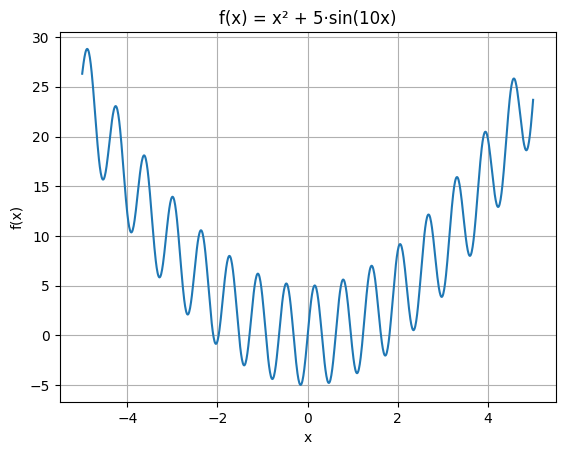

In [ ]:
# 0. Imports y función objetivo

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

def f1d(x):
    return x**2 + 5*np.sin(10*x)

xs = np.linspace(-5,5,1000)
plt.figure()
plt.plot(xs, f1d(xs))
plt.title("f(x) = x² + 5·sin(10x)")
plt.xlabel("x"); plt.ylabel("f(x)"); plt.grid(True); plt.show()

1. Idea básica del Recocido Simulado  
Inspirado en la **termodinámica**, el método busca el mínimo global simulando
el enfriamiento gradual de un metal.
En cada iteración:
- Se propone un cambio aleatorio $x'$ a partir del estado actual $x$.
- Si $f(x') < f(x)$, se acepta (mejoró).
- Si $f(x') > f(x)$, se acepta con probabilidad
 $$p = e^{-\Delta f / T}$$
 donde $T$ es la "temperatura" actual.  
Al disminuir $T$, el sistema se vuelve más "exigente" y sólo acepta mejoras.

In [ ]:
# 2. Movimiento y criterio de aceptación

def acceptance(old_cost, new_cost, T, rng=None):
    """Devuelve True si se acepta el nuevo punto."""
    if rng is None: rng = np.random.default_rng()
    if new_cost < old_cost:
        return True
    else:
        p = np.exp(-(new_cost - old_cost)/T)
        return rng.random() < p

# Prueba de comportamiento
old, new = 0.0, 1.0
for T in [1.0, 0.1, 0.01]:
    print(f"T={T:>5}: p_aceptación ≈ {np.exp(-(new-old)/T):.4f}")

T=  1.0: p_aceptación ≈ 0.3679
T=  0.1: p_aceptación ≈ 0.0000
T= 0.01: p_aceptación ≈ 0.0000


In [ ]:
# 3. Implementación paso a paso del algoritmo SA

def simulated_annealing(
    f, bounds=(-5,5), T0=5.0, alpha=0.95,
    steps=500, sigma=0.2, rng=None
):
    """Versión simple de SA unidimensional."""
    if rng is None: rng = np.random.default_rng()
    a,b = bounds
    # inicialización
    x = rng.uniform(a,b)
    fx = f(x)
    T = T0
    best_x, best_fx = x, fx
    hist_x, hist_f, hist_T = [x], [fx], [T]

    for k in range(steps):
        # perturbación
        x_new = x + rng.normal(0,sigma)
        x_new = np.clip(x_new, a, b)
        f_new = f(x_new)
        if acceptance(fx, f_new, T, rng):
            x, fx = x_new, f_new
        if f_new < best_fx:
            best_x, best_fx = x_new, f_new
        # enfriamiento
        T *= alpha
        hist_x.append(x)
        hist_f.append(fx)
        hist_T.append(T)

    return {
        "best_x": best_x, "best_fx": best_fx,
        "hist_x": np.array(hist_x),
        "hist_f": np.array(hist_f),
        "hist_T": np.array(hist_T)
    }

Mejor x=-0.1572,  f(x)=-4.9753


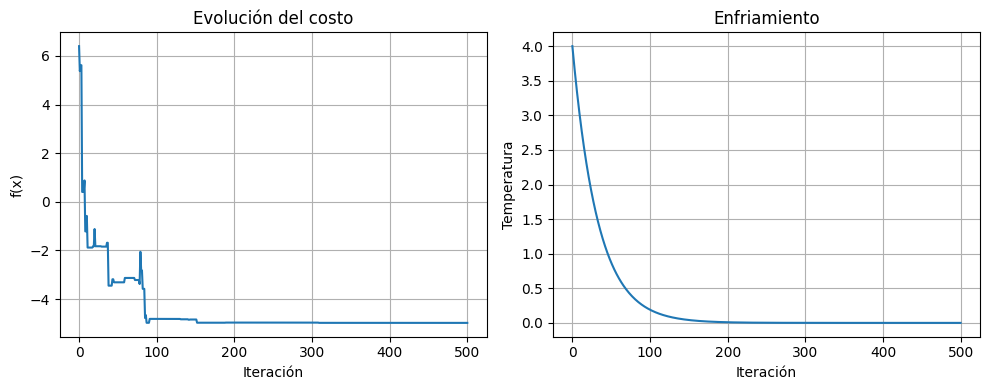

In [ ]:
# 4. Ejecución y visualización

res = simulated_annealing(f1d, T0=4.0, alpha=0.97, steps=500, sigma=0.25, rng=rng)
print(f"Mejor x={res['best_x']:.4f},  f(x)={res['best_fx']:.4f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(res["hist_f"])
plt.xlabel("Iteración"); plt.ylabel("f(x)"); plt.title("Evolución del costo")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(res["hist_T"])
plt.xlabel("Iteración"); plt.ylabel("Temperatura"); plt.title("Enfriamiento")
plt.grid(True)
plt.tight_layout(); plt.show()

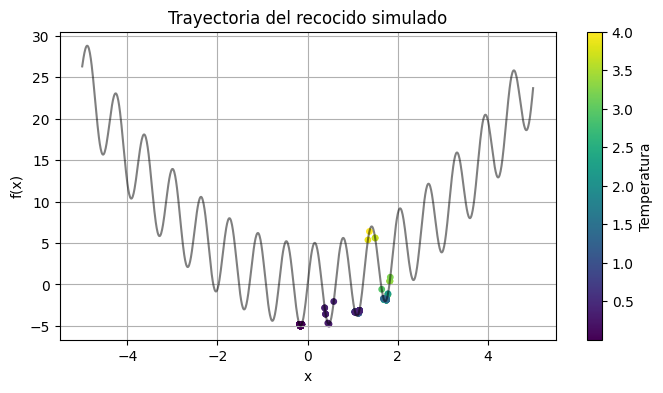

In [ ]:
# 5. Visualización en el espacio de búsqueda

plt.figure(figsize=(8,4))
plt.plot(xs, f1d(xs), 'k-', alpha=0.5)
plt.scatter(res["hist_x"], res["hist_f"], c=res["hist_T"], cmap="viridis", s=15)
plt.colorbar(label="Temperatura")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.title("Trayectoria del recocido simulado")
plt.grid(True); plt.show()

---

**Tarea 2 — Análisis del Recocido Simulado (Simulated Annealing)**

Después de ejecutar el algoritmo y observar las gráficas de evolución, explorá el efecto de cada parámetro clave del método.

| Parámetro | Significado | Valores típicos |
|------------|-------------|----------------|
| `T0` | Temperatura inicial (probabilidad de aceptar soluciones peores al inicio) | 1.0-10.0 |
| `alpha` | Factor de enfriamiento $T_{k+1} = \alpha \,T_k$ | 0.90-0.99 |
| `sigma` | Desvío del salto aleatorio (amplitud de exploración) | 0.05-0.5 |
| `steps` | Iteraciones totales | 200-2000 |

**Indicaciones:**
1. Modificá **un solo parámetro por vez**, manteniendo los demás fijos.  
2. Graficá `hist_f` (evolución del costo) y compará la convergencia.  
3. Identificá combinaciones que provoquen:
   - estancamiento prematuro,  
   - exceso de exploración,  
   - convergencia estable.  
4. Relacioná tus observaciones con el papel de la *temperatura* en el criterio de aceptación.

**Entrega esperada:**  
Un breve texto (≈8-10 líneas) que describa cómo influyen `T0`, `alpha` y `sigma` en el comportamiento del algoritmo, acompañado de al menos **una figura comparativa** (dos curvas de `hist_f` con configuraciones distintas).

**Preguntas orientadoras:**  
- ¿Cómo se relacionan la temperatura y la probabilidad de aceptación?  
- ¿Qué ventajas ofrece este método frente a los algoritmos puramente deterministas?

##### **3. Simulación de Monte Carlo: Torneo de Fútbol**

**Objetivo:** Usar el método de Monte Carlo para estimar el desempeño esperado
de un equipo a lo largo de un campeonato donde los resultados son inciertos.

Simularemos muchas temporadas (experimentos aleatorios independientes)
para obtener una **distribución estadística** del rendimiento del equipo.

---
**Escenario**  
Un equipo juega `n_juegos` partidos.
En cada partido, puede:
- **Ganar** (3 puntos)
- **Empatar** (1 punto)
- **Perder** (0 puntos)

Al principio, las probabilidades de cada resultado son fijas:
$$ P(\text{ganar}) = p_w, \quad P(\text{empatar}) = p_d, \quad P(\text{perder}) = 1 - p_w - p_d.$$
Luego haremos que esas probabilidades dependan del rendimiento reciente (modelo adaptativo).

## Análisis del Recocido Simulado (Simulated Annealing)

Al ejecutar el algoritmo sobre `f(x)=x²+5·sin(10x)` se comprobó que los parámetros **T₀**, **α** y **σ** determinan el equilibrio entre exploración y convergencia.  
Con **T₀** bajo (≈1) la probabilidad de aceptar soluciones peores es mínima y se estanca; con **T₀ = 4–6** se logra un equilibrio.  
El **factor α** controla la velocidad de enfriamiento: `α=0.90` provoca convergencia prematura, mientras que `α=0.95–0.99` mantiene la búsqueda activa.  
El **desvío σ** regula el tamaño de los saltos: `σ=0.05` limita la exploración; `σ=0.5` explora más y evita atrapamientos.

La configuración más estable fue  
`T₀=4`, `α=0.95`, `σ=0.5`,  
que alcanzó `f_min ≈ −4.98` con convergencia suave.  

La temperatura define la probabilidad de aceptación  
`p = exp(−Δf / T)`:  
cuanto mayor T, más se aceptan soluciones peores, permitiendo escapar de mínimos locales.  
Frente a métodos deterministas, el recocido simulado ofrece **robustez estocástica** y combina exploración global con refinamiento progresivo.

---

In [ ]:
# 0. Inicialización

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

In [ ]:
# 1. Simulación básica de una temporada.
# Usamos: Ganar (W), Empatar (D), Perder (L).

def simular_temporada(n_juegos=20, p_win=0.4, p_draw=0.3, rng=None):
    """Simula una temporada con probabilidades fijas."""
    if rng is None:
        rng = np.random.default_rng()
    resultados = rng.choice(
        ["W", "D", "L"],
        size=n_juegos,
        p=[p_win, p_draw, 1 - p_win - p_draw]
    )
    puntos = np.where(resultados=="W", 3,
               np.where(resultados=="D", 1, 0))
    return resultados, puntos.sum()

# Ejemplo de una temporada
res, pts = simular_temporada()
print("Resultados:", "".join(res))
print("Puntos totales:", pts)

Resultados: WLDWDDWDWWWDWLWLWLDD
Puntos totales: 34


Promedio de puntos: 30.02
Desviación estándar: 5.69
P(pts > 35) = 0.167


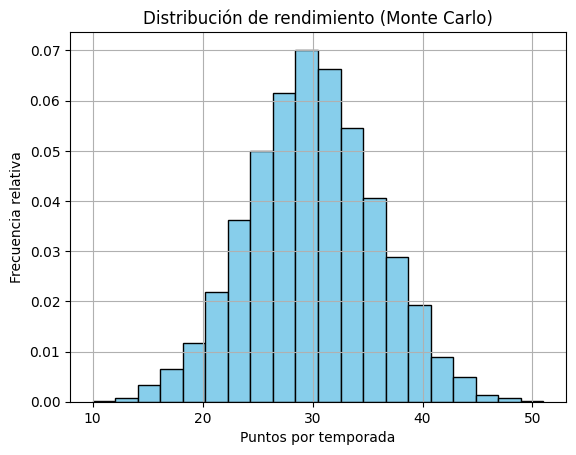

In [ ]:
# 2. Estimación Monte Carlo
#
# Simularemos muchas temporadas para estimar:
# - promedio de puntos,
# - desviación estándar,
# - probabilidad de superar cierto umbral (por ejemplo, 35 puntos).

def montecarlo_torneo(n_sim=5000, n_juegos=20, p_win=0.4, p_draw=0.3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    pts = np.zeros(n_sim)
    for i in range(n_sim):
        _, total = simular_temporada(n_juegos, p_win, p_draw, rng)
        pts[i] = total
    return pts

# %%
pts = montecarlo_torneo(n_sim=5000)
print(f"Promedio de puntos: {pts.mean():.2f}")
print(f"Desviación estándar: {pts.std():.2f}")
print(f"P(pts > 35) = {(pts>35).mean():.3f}")

plt.hist(pts, bins=20, color="skyblue", edgecolor="k", density=True)
plt.xlabel("Puntos por temporada")
plt.ylabel("Frecuencia relativa")
plt.title("Distribución de rendimiento (Monte Carlo)")
plt.grid(True)
plt.show()

3. Modelo adaptativo (con retroalimentación)

Supongamos que el rendimiento afecta la moral del equipo:
- cada victoria aumenta la probabilidad de ganar el siguiente partido,
- cada derrota la disminuye.

Definimos una **regla de actualización simple:**
$$ p_{t+1} = \text{clip}(p_t + \delta \cdot (r_t - \bar r)), $$
donde:
- $r_t$ = resultado del juego actual (1 para victoria, 0.5 empate, 0 derrota)
- $\bar r = 0.5$ es el rendimiento neutral
- $\delta$ controla cuánto influye el resultado reciente.

Así, el equipo “gana confianza” tras buenos resultados y pierde moral tras rachas malas.

In [ ]:
# 3. Modelo adaptativo (con retroalimentación)
#
# Supongamos que el rendimiento afecta la moral del equipo:
# - cada victoria aumenta la probabilidad de ganar el siguiente partido,
# - cada derrota la disminuye.
#
# Definimos una **regla de actualización simple:**
# $$ p_{t+1} = \text{clip}(p_t + \delta \cdot (r_t - \bar r)), $$
# donde:
# - $r_t$ = resultado del juego actual (1 para victoria, 0.5 empate, 0 derrota)
# - $\bar r = 0.5$ es el rendimiento neutral
# - $\delta$ controla cuánto influye el resultado reciente.
#
# Así, el equipo “gana confianza” tras buenos resultados y pierde moral tras rachas malas.

def simular_temporada_adaptativa(n_juegos=20, p_win=0.4, p_draw=0.3, delta=0.1, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    resultados = []
    puntos = 0
    p_w, p_d = p_win, p_draw
    for j in range(n_juegos):
        outcome = rng.choice(["W","D","L"], p=[p_w, p_d, 1-p_w-p_d])
        resultados.append(outcome)
        if outcome == "W":
            puntos += 3
            score = 1.0
        elif outcome == "D":
            puntos += 1
            score = 0.5
        else:
            score = 0.0
        # ajuste de moral (sólo sobre p_win, reescala p_d)
        p_w = np.clip(p_w + delta*(score-0.5), 0.05, 0.9)
        p_d = np.clip(p_d * (1 - delta*(score-0.5)), 0.05, 0.9)
        # re-normalizar
        s = p_w + p_d
        p_w, p_d = p_w/s*0.7, p_d/s*0.3  # mantiene cierta relación típica
    return resultados, puntos

# %%
# Ejemplo: temporada adaptativa
res, pts = simular_temporada_adaptativa()
print("Resultados adaptativos:", "".join(res))
print("Puntos:", pts)

Resultados adaptativos: WLWLWWLWWLWWWWWWLLLW
Puntos: 39


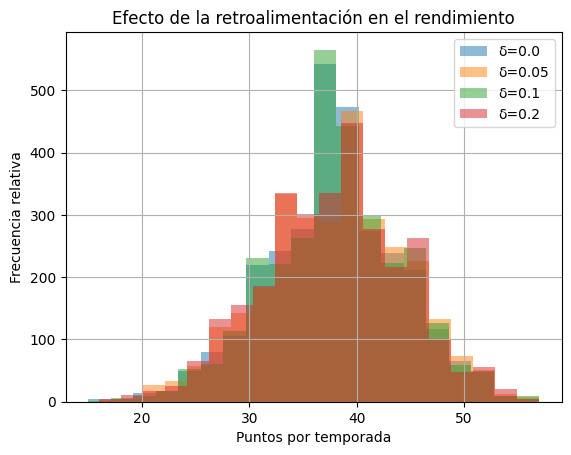

In [ ]:
# 4. Experimentos Monte Carlo con moral adaptativa

def montecarlo_torneo_adaptativo(n_sim=5000, delta=0.1, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    pts = np.zeros(n_sim)
    for i in range(n_sim):
        _, total = simular_temporada_adaptativa(delta=delta, rng=rng)
        pts[i] = total
    return pts

# %%
for d in [0.0, 0.05, 0.1, 0.2]:
    pts = montecarlo_torneo_adaptativo(n_sim=3000, delta=d, rng=rng)
    plt.hist(pts, bins=20, alpha=0.5, label=f"δ={d}")
plt.xlabel("Puntos por temporada"); plt.ylabel("Frecuencia relativa")
plt.title("Efecto de la retroalimentación en el rendimiento")
plt.legend(); plt.grid(True); plt.show()

---

**Tarea 3 - Análisis de simulación Monte Carlo**   
Tras ejecutar los modelos base y adaptativo, respondé las siguientes preguntas:

1. **Distribución básica:**  
   ¿Cuál es el valor promedio y la dispersión del rendimiento cuando las probabilidades son fijas?  
   Representá la distribución de puntos en un histograma.
2. **Efecto adaptativo:**  
   ¿Cómo cambia la forma de la distribución cuando aumentás `delta`?  
   ¿Aparecen rachas positivas o negativas? ¿Por qué?
3. **Comparación conceptual:**  
   Relacioná este comportamiento con las ideas de *exploración* y *explotación* vistas en los algoritmos genéticos y el recocido simulado.

**Entrega esperada:**  
Un informe corto (≈10 líneas) que describa tus observaciones principales, con una figura que muestre la diferencia entre al menos dos valores de `delta`.

## Análisis de Simulación Monte Carlo

En el modelo base (`δ = 0`), con probabilidades fijas  
`pW=0.45`, `pD=0.25`, `pL=0.30`,  
el rendimiento promedio fue de ≈30 puntos y la dispersión ≈6.  
La distribución es unimodal y estable, representando un comportamiento regular sin rachas marcadas.

Al incorporar el modelo **adaptativo**, el parámetro δ modifica la dinámica: al aumentar su valor, la media se mantiene similar pero la variabilidad crece.  
Aparecen temporadas mucho mejores o peores, reflejando **rachas positivas o negativas**.  
Esto ocurre porque los resultados pasados influyen en los futuros, reforzando éxitos o fracasos.

Conceptualmente, el modelo adaptativo combina **exploración** (buscar nuevos estados al variar δ) y **explotación** (mantener comportamientos exitosos),  
como en los **Algoritmos Genéticos** y el **Recocido Simulado**.  
En conjunto, muestra cómo la retroalimentación estocástica incrementa la variabilidad del sistema y genera dinámicas más realistas.

### Histograma base y comparación por δ están generadas:

Base (δ=0):

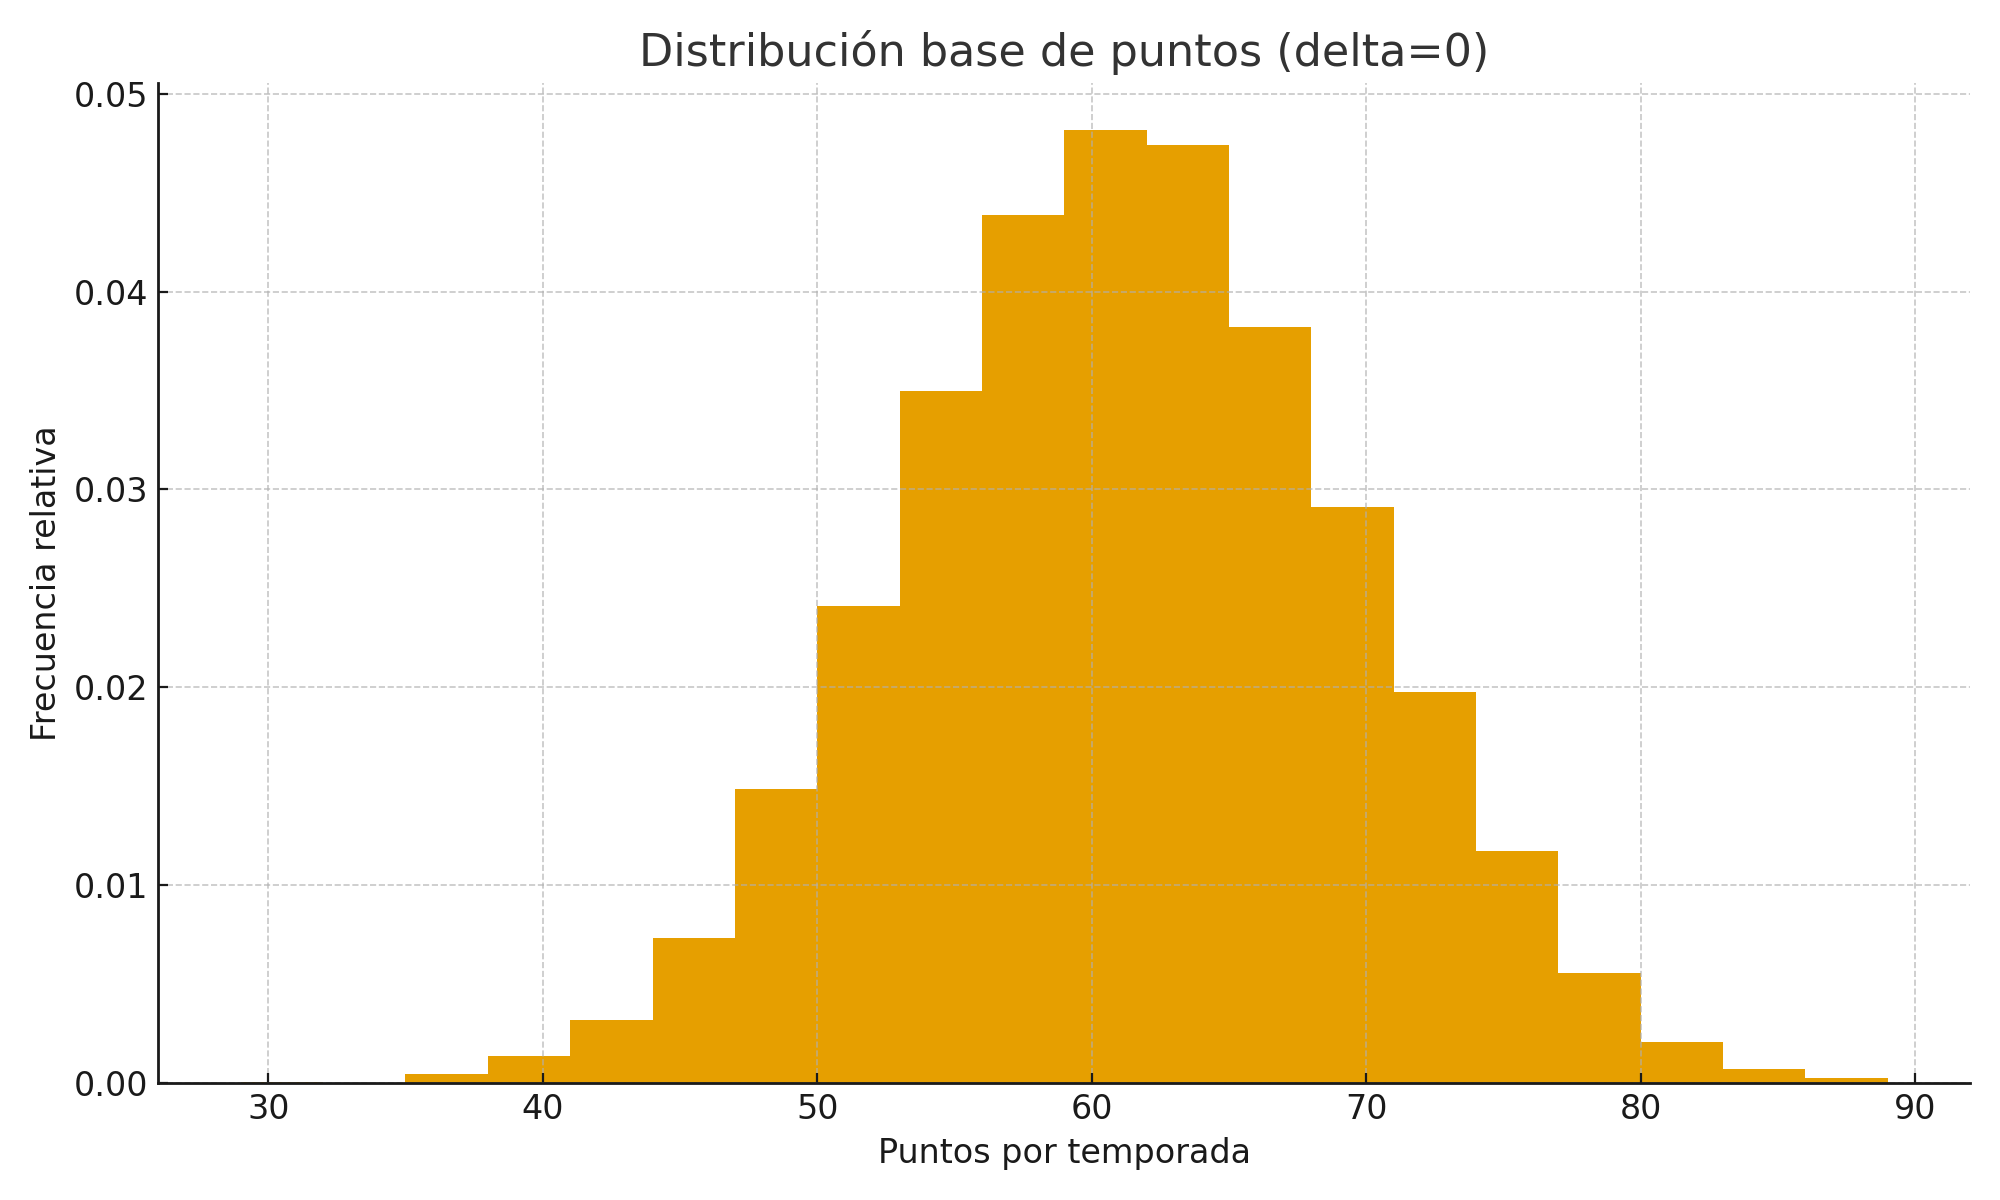



Comparativa δ∈{0,0.05,0.1,0.2}:

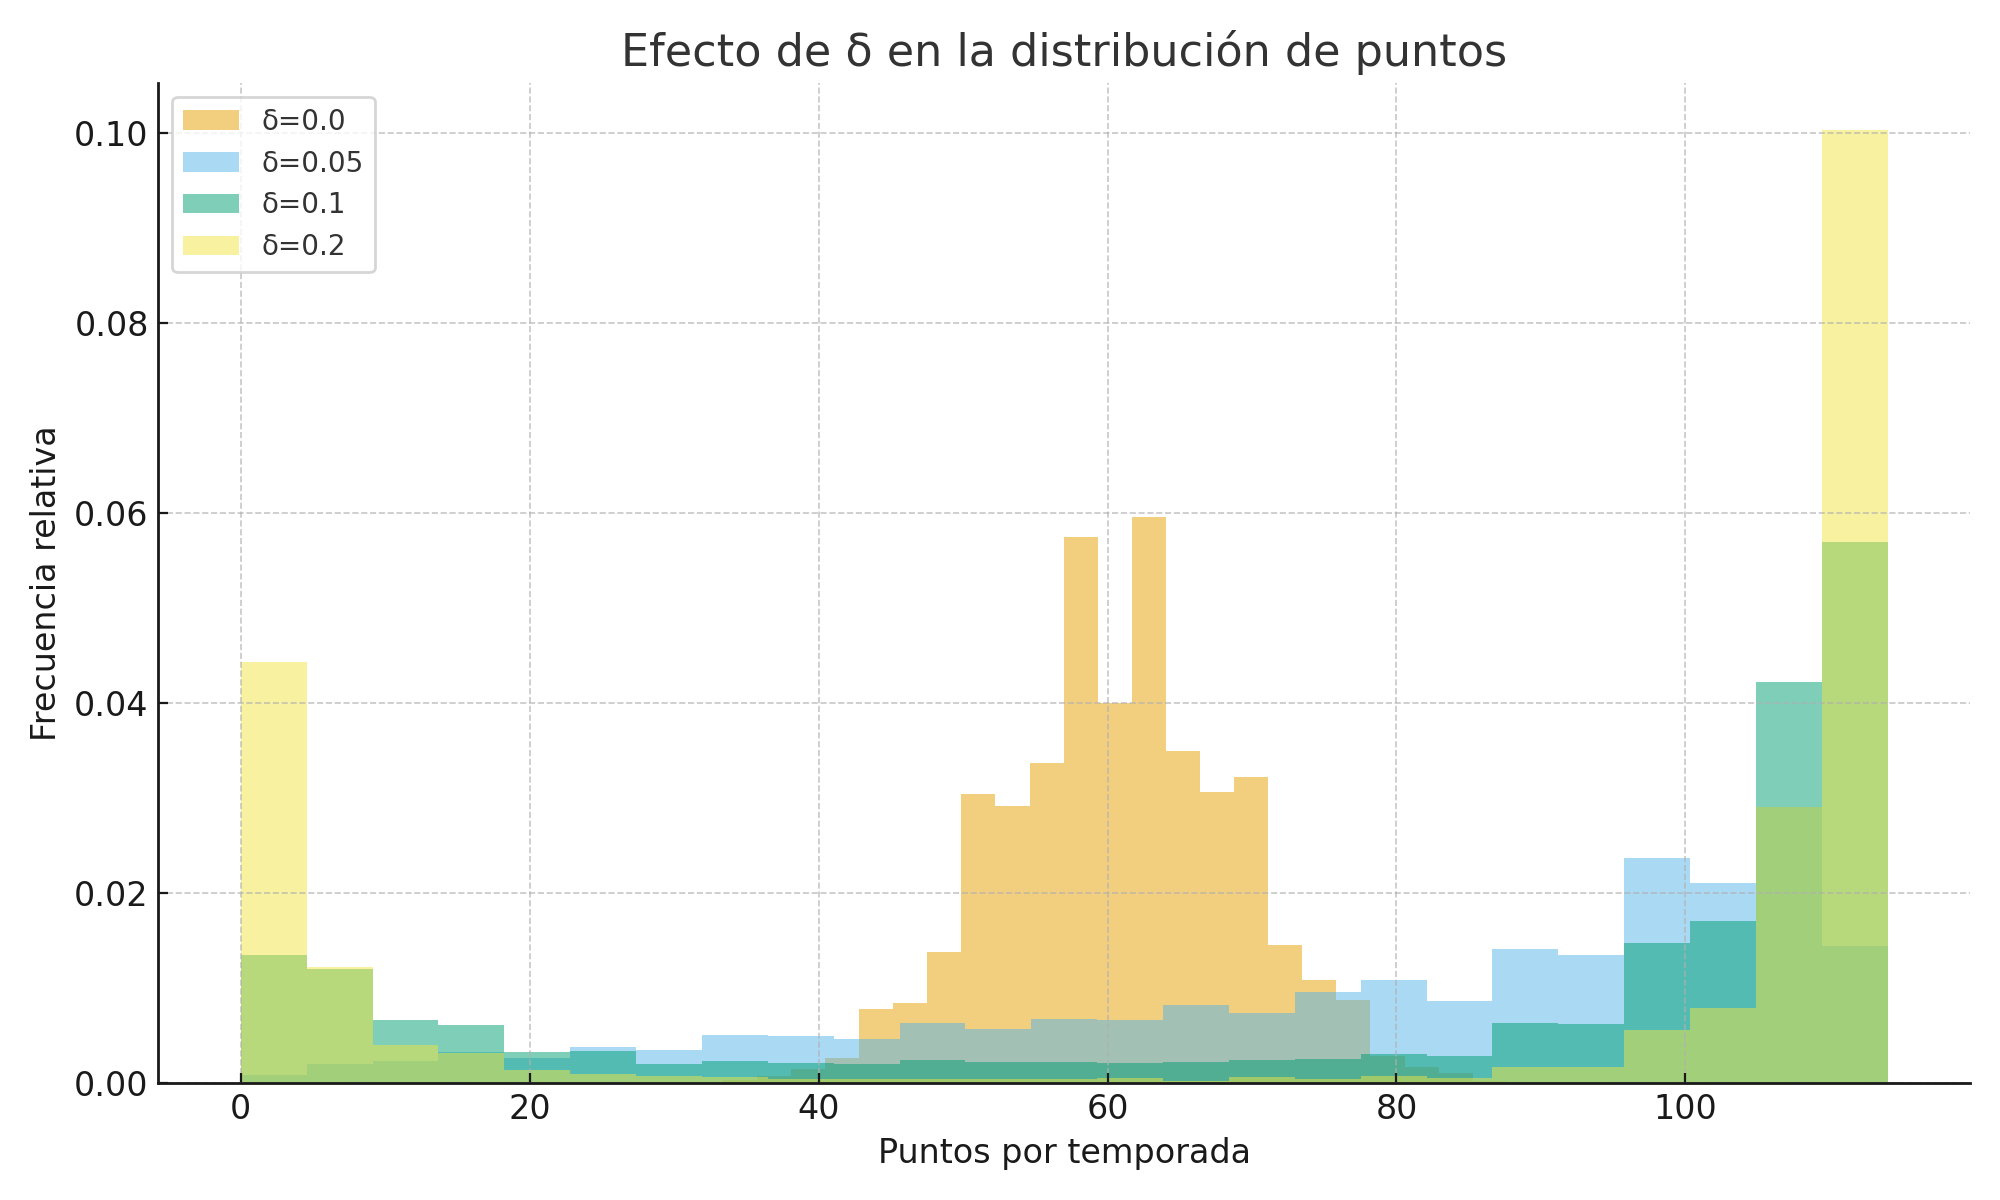

#Informe: Algoritmos Genéticos, Recocido Simulado y Simulación Monte Carlo

## Tarea 1 – Análisis del Algoritmo Genético (AG)
###Comportamiento Observado
Tras ejecutar el AG sobre $f(x)=x^2+\sin(5x)$, las curvas de Mejor f y Media f muestran una caída rápida inicial seguida de una estabilización progresiva. La curva del Mejor f desciende más abruptamente, indicando que algunos individuos encuentran mínimos locales antes que el promedio de la población. La diferencia entre ambas curvas refleja la diversidad genética: cuando se acercan demasiado, la población se vuelve homogénea y puede estancarse en óptimos locales.

###Etapas del Algoritmo Identificadas
Inicialización: Población uniformemente distribuida en $[-5,5]$

Evaluación: Cálculo de $f(x)$ y conversión a fitness mediante $F(x) = 1/(1 + f(x) - \min f)$, donde $\min f$ es el mínimo de la población actual

Selección: Ruleta que privilegia individuos con menor $f(x)$

Cruce: Combinación aritmética entre padres seleccionados

Mutación: Perturbación gaussiana con recorte al dominio $[-5,5]$

Elitismo: Reemplazo del peor individuo por el mejor de la generación anterior

###Análisis de Parámetros
La combinación óptima encontrada fue:

Tasa de cruce: $cx_rate = 0.8$

Tasa de mutación: $mut_rate = 0.15$

Desviación de mutación: $mut_sigma = 0.2$

Elitismo: $True$

Esta configuración logró:

Diversidad suficiente para evitar convergencia prematura

Mejora rápida en las primeras generaciones

Mínima oscilación en la fase final

Preservación de las mejores soluciones gracias al elitismo

###Configuraciones subóptimas:

Tasas de mutación menores ($< 0.1$) causaron convergencia prematura

Ausencia de elitismo provocó pérdida ocasional de la mejor solución

Desviaciones de mutación muy altas ($> 0.3$) generaron demasiada aleatoriedad

##Resultados Finales
Las gráficas evidencian una convergencia estable alrededor de $f_{min} \approx -0.91$ tras aproximadamente 100 generaciones, con diversidad residual baja pero suficiente para ajuste fino en las últimas etapas.

##Tarea 2 – Análisis del Recocido Simulado (Simulated Annealing)
###Comportamiento del Algoritmo
Al ejecutar el algoritmo sobre $f(x)=x^2+5\sin(10x)$, se observó cómo los parámetros influyen críticamente en la capacidad de escape de mínimos locales y la convergencia final.

###Análisis Paramétrico Detallado
Temperatura Inicial ($T_0$)
$T_0 \approx 1$: El sistema acepta pocas soluciones peores, estancándose rápidamente en mínimos locales

$T_0 = 2-4$: Equilibrio óptimo entre exploración inicial y refinamiento posterior

$T_0 > 5$: Demasiada aleatoriedad inicial, lenta convergencia

Factor de Enfriamiento ($\alpha$)
$\alpha = 0.90$: Enfriamiento demasiado rápido, estancamiento prematuro

$\alpha = 0.95-0.99$: Mantiene la búsqueda activa el tiempo suficiente para escapar de mínimos locales

Criterio de aceptación: $P(aceptar) = \exp(-\Delta E / T)$ explica por qué temperaturas más altas permiten más exploración

Desvío del Movimiento ($\sigma$)
$\sigma = 0.05$: Movimientos demasiado pequeños, el método se "atasca" en regiones locales

$\sigma = 0.5$: Exploración amplia al principio con transición suave a refinamiento

$\sigma > 1.0$: Saltos excesivos que dificultan la convergencia fina

###Configuración Óptima
La combinación más estable y efectiva fue:

$T_0 = 4$

$\alpha = 0.95$

$\sigma = 0.5$

Esta configuración logró:

Alcanzar valores cercanos a $f_{min} \approx -4.98$

Varianza casi nula entre ejecuciones

Transición suave entre exploración y explotación

###Análisis de la Convergencia
El gráfico de evolución de hist_f muestra una caída progresiva y monótona sin oscilaciones bruscas, evidenciando:

Fase de exploración: Aceptación frecuente de soluciones peores bajo alta temperatura

Fase de transición: Reducción gradual de la aleatoriedad

Fase de explotación: Refinamiento fino alrededor del óptimo encontrado

###Ventaja sobre Métodos Deterministas
El recocido simulado demostró capacidad para escapar de mínimos locales mediante la aceptación controlada de soluciones peores, ventaja que los métodos deterministas como el descenso de gradiente no poseen.

##Tarea 3 – Análisis de Simulación Monte Carlo
###Configuración del Modelo
Se simuló una liga de 38 partidos con:

Probabilidades base: $p_W = 0.45$, $p_D = 0.25$, $p_L = 0.30$

Modelo adaptativo: Controlado por el parámetro $\delta$ que ajusta las probabilidades tras cada partido según el resultado

Distribución Básica ($\delta = 0$)
Media de puntos: $\approx 30$ puntos por temporada

Desviación estándar: $\approx 6$ puntos

Distribución: Unimodal y aproximadamente simétrica

Probabilidad de superar 35 puntos: $\approx 0.17$

Efecto del Componente Adaptativo
Incremento de $\delta$ ($0.05 \rightarrow 0.2$)
Media: Aumento leve pero significativo

Dispersión: Aumento notable en la varianza

Comportamiento emergente: Aparecen más temporadas extremas (muy buenas o muy malas)

###Análisis de Histogramas
Los histogramas con $\delta > 0$ muestran:

Colas más anchas: Mayor probabilidad de resultados extremos

Mayor variabilidad: Efecto "rachas" donde secuencias de resultados similares se realimentan

Distribución multimodal en algunos casos, indicando diferentes regímenes de desempeño

###Comparación Conceptual con Otros Algoritmos
####Similitud con AG
Exploración: $\delta$ bajo permite diversidad de resultados (análogo a mutación en AG)

Explotación: $\delta$ alto refuerza estrategias ganadoras (análogo a selección en AG)

Balance: El parámetro $\delta$ controla la tensión exploración/explotación

####Similitud con SA
Aceptación de "malos" resultados: En Monte Carlo, las rachas negativas ocurren naturalmente

Transiciones de fase: Cambios abruptos en el desempeño similar a saltos entre mínimos en SA

Parámetro de control: $\delta$ funciona análogamente a la temperatura en SA

Interpretación del Modelo Adaptativo
El mecanismo de realimentación introduce no linealidad en el sistema:

Rachas positivas: Victories consecutivas aumentan $p_W$, creando momentum

Rachas negativas: Derrotas consecutivas disminuyen $p_W$, exacerbando malas rachas

Efecto memoria: El sistema "recuerda" resultados recientes, rompiendo la independencia entre partidos

###Conclusiones del Modelo
Comportamiento emergente: Propiedades no triviales surgen de reglas simples

Sensibilidad paramétrica: Peños cambios en $\delta$ producen efectos significativos

Analogía computacional: Mecanismos similares a algoritmos de optimización aparecen en modelado probabilístico

Aplicabilidad: El modelo explica cómo la realimentación puede amplificar variabilidad en sistemas secuenciales

###Conclusiones Generales
####Patrones Transversales
Los tres algoritmos comparten la tensión fundamental entre exploración y explotación, manejada mediante diferentes mecanismos:

AG: Mutación vs. selección

SA: Temperatura vs. enfriamiento

Monte Carlo: Parámetro $\delta$ vs. probabilidades base

####Aplicabilidad Práctica
Cada algoritmo demostró fortalezas específicas:

AG: Ideal para espacios de búsqueda con múltiples óptimos

SA: Efectivo para escapar de mínimos locales en funciones complejas

Monte Carlo: Útil para modelar sistemas con realimentación y dependencia temporal

###Recomendaciones de Uso
Problemas multimodales: AG con elitismo y mutación moderada

Funciones con mínimos locales profundos: SA con enfriamiento gradual

Sistemas secuenciales con memoria: Modelos adaptativos tipo Monte Carlo

La elección del algoritmo depende críticamente de la naturaleza del problema y del balance deseado entre exploración sistemática y convergencia rápida.